## Predicting farms' emission reduction

In my master's thesis I conceptualize and estimate an agricultural cost function using Econometric Mathematical Programming using GAMS. I apply the developed model to simulate the introduction of a GHG emission cap-and-trade system for French dairy, cattle and crop farms. 

The model simulates the production decision for each farm under a regional emission constraint. As the farms can trade emission rights among each other, not all farms reduce their emissions equally: For some farms it is economically more viable to buy emission rights from other farms that entitle them to emit more than the average farm. In other words: If the emissions from agriculture within one region have to be reduced by 10%, for example, some farms will reduce their emissions by more than 10% while others will reduce them by less than 10% - the former farms become net sellers of emission rights and the latter farms become net buyers.

This project shows how __K-Nearest Neighbor__ classification, __Logistic Regression__ and __Support Vector Machines__ may be used to predict, based on two farm features, if a dairy farm will become a net buyer or a net seller of emission rights, if an emission cap is imposed.

__warning!__ This Python project is purely demonstrational - using either of these three algorithms might be like taking a sledgehammer to crack a nut. The number of observations (ca. 230) and of features (two) is pretty small. In fact, a look at the model that _produced_ the results that are analysed below already reveals a lot about the drivers behind a farm's emission reduction. Consider this file as a training project to practice the use of Scikit learn...

This project is structured as follows:
1. Data import and preparation
2. Visualization - understanding the data
3. Classification
 - KNN
 - Logistic regression
 - SVM
4. Using one algorithm to predict "untouched" data
 

In [1]:
#import some standard libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#import some useful sklearn modules
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from scipy.special import expit, logit
from sklearn.metrics import classification_report,confusion_matrix

#import the modules used for classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

### 1. Data import and preparation

one reference simulation and 8 emission reduction scenarios were performed with GAMS, with a GHG cap implemented at regional level:
- ref (reference scenario, 2012)
- scen1 (2.5% GHG reduction relative to reference scenario)
- ...
- scen8 (20.0% reduction)

the following information is retrieved from the input files for this analysis:
- simulated (aggregate) activity levels per farm and for each scenario
- emission factor "pCO2"(GHG emissions per activity level). It varies between farms (depends on the disaggregated activities)
- GHG emissions per farm and per scenario: product of a farm's simulated activity levels and each activity's emission factor 



In [92]:
#use the excel file "dairy emission cap results.xlsx" as input
input_file_path= r"C:\Your file path\dairy emission cap results.xlsx"

farm_emissions =pd.read_excel(input_file_path, sheet_name="farm_emissions")  #information on GHG emissions per farm
sim_activity_level=pd.read_excel(input_file_path, sheet_name="ysim")  #simulated activity levels for each farm
pCO2=pd.read_excel(input_file_path, sheet_name="pCO2")  #emission factor: GHG emissions (CO2-eq) per activity level

In [4]:
farm_emissions.head() #r1: region dummy (always 5), r2: subregion dummmy (501-503), fid: farm ident.,
# scen: emission reduction scenario, emissions: GHG emissions in tons (weighted by farmweight))

,year,r1,r2,fid,scen,emissions
0,2012,5,501,3240000004751,ref,8474.28
1,2012,5,501,3240000004751,scen1,8244.17
2,2012,5,501,3240000004751,scen2,7973.27
3,2012,5,501,3240000004751,scen3,7687.74
4,2012,5,501,3240000004751,scen4,7390.04


In [5]:
sim_activity_level.head() #m: activity (a=dairy outputs, b=other bovine outputs, c=non-bovine animal outputs, d=crops
# ysim: simulated activity level (quantity measured in 10 000 base-year €)

,year,r1,r2,fid,m,scen,ysim
0,2012,5,501,3240000004751,a,ref,2.37818
1,2012,5,501,3240000004751,a,scen1,2.30015
2,2012,5,501,3240000004751,a,scen2,2.20829
3,2012,5,501,3240000004751,a,scen3,2.11147
4,2012,5,501,3240000004751,a,scen4,2.01051


In [6]:
pCO2.head() #pCO2: GHG emissions in t per activity level

,year,r1,r2,fid,m,pCO2
0,2005,5,501,3240000004751,a,0.003917
1,2005,5,501,3240000004751,b,0.004893
2,2005,5,501,3240000004751,d,0.005058
3,2005,5,501,3240000004867,a,0.004852
4,2005,5,501,3240000004867,b,0.005537


In [7]:
#calculate the sum of all activity levels per farm produced in the reference scenario, as a measure of the farm's size
def farm_activity_level_ref(fid):
    return float(sim_activity_level[(sim_activity_level['scen']=='ref')&(sim_activity_level['fid']==fid)]['ysim'].sum())

#calculate the relative emissions of a farm, in relation to its total emissions in the reference scenario
def rel_farm_emissions(fid, emissions):
    ref_em=float(farm_emissions[(farm_emissions['fid']==fid)&(farm_emissions['scen']=='ref')]['emissions'])
    return(emissions/ref_em)

In [8]:
#add a column with the farm's total activity level in the reference scenario
farm_emissions['farm_activity_level_ref']=farm_emissions.apply(lambda x: farm_activity_level_ref(x.fid), axis=1)
#add a column with the farm's emission in each scenario relative to its reference emissions
farm_emissions['rel_farm_emissions']=farm_emissions.apply(lambda x: rel_farm_emissions(x.fid, x.emissions), axis=1)

In [9]:
sim_activity_level=sim_activity_level.merge(pCO2, how='left', on=['year','r1','r2','fid','m'])

### 2. Visualization - understanding the data

Does a farm's _relative_ emission reduction depend on the quantity of activities produced in the reference scenario?
In fact, we assume it does: farms all must reduce their Marginal Costs (MC) by the same amount (you find an explanation in the attached theoretical documents). Farms can change their MC by changing their activity levels - as the cost function is convex, MC _increase_ in activity levels (however, there is some complicated interaction between activities). Therefore, farms must decrease their activity levels to decrease MC. As farms must adapt their MC equally, and as their MC change equally in activity levels, large farms must reduce their activity levels relatively little. As emissions depend on activity levels, we assume that they reduce their emissions comparably little.

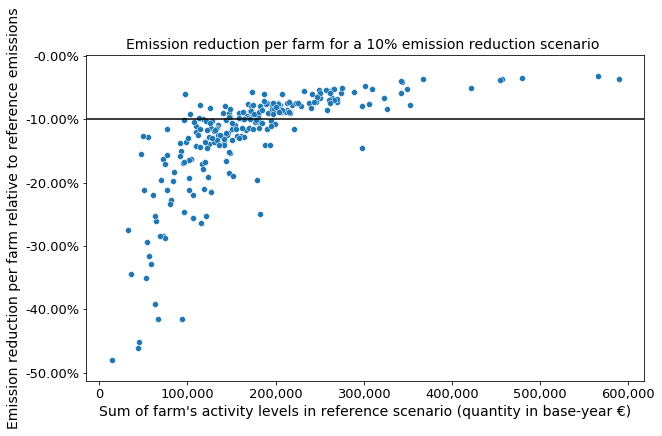

In [10]:
plt.figure(figsize=(10,6))
g=sns.scatterplot(x='farm_activity_level_ref', y='rel_farm_emissions', 
                  data=farm_emissions[farm_emissions['scen']=='scen4'])

plt.xlabel("Sum of farm's activity levels in reference scenario (quantity in base-year €)", size=14)
plt.ylabel("Emission reduction per farm relative to reference emissions", size=14)
plt.title("Emission reduction per farm for a 10% emission reduction scenario ", size=14)
#g.set_yticklabels(g.get_yticks(), size = 14)
#g.set_xticklabels(g.get_xticks(), size = 13)
ylabels = ['{:,.2f}'.format(-(100-y*100))+'%' for y in g.get_yticks()]
g.set_yticklabels(ylabels, size = 13)
xlabels = ['{:,.0f}'.format(x*10000) for x in g.get_xticks()] #activity level is in 10000 base-year €
g.set_xticklabels(xlabels, size = 13)
g.axhline(0.9, color='black')

note: the black horizontal line indicates by how much the _regional_ emissions must be reduced - this doesn't mean each farm reduced it by the same amount! The farms that reduce their emissions by less than 10% (in the above example) are __net buyers__ of emission rights, the others (below the horizontal line) are __net sellers__.

The farm's reference activity level ( --> proportional to the farm's size) seems to matter. But why do some farms, with the same reference activity level, exhibit a different emission reduction behaviour? <br>
--> because the emissions _per activity level_ matter. If an activity leads to high emissions per level, it has comparably low emission reduction costs. Why? Remember that emissions per activity differ between farms. All farms receive the same price per output (in our model), therefore a farm with higher emissions per output has lower opportunity costs _per emission_ if it stops producing this output.

In [11]:
#identify all farms:
allfids=list(farm_emissions['fid'].value_counts().keys())

In [12]:
#calculate the mean emission factor per activity for each farm
weighted_mean_pCO2={'fid':[], 'weighted_mean_pCO2':[]}
for fid in allfids:
    a=list(sim_activity_level[(sim_activity_level['scen']=='ref')&(sim_activity_level['fid']==fid)]['pCO2'])
    b=list(sim_activity_level[(sim_activity_level['scen']=='ref')&(sim_activity_level['fid']==fid)]['ysim'])
    counter=0
    for i,m in enumerate(a):
        counter+=float(m)*float(b[i])
    weighted_mean_pCO2['fid'].append(fid)
    weighted_mean_pCO2['weighted_mean_pCO2'].append(counter/sum(b))

weighted_mean_pCO2_df=pd.DataFrame(weighted_mean_pCO2)

In [13]:
def assign_weighted_mean_pCO2(fid):
    return float(weighted_mean_pCO2_df[weighted_mean_pCO2_df['fid']==fid]['weighted_mean_pCO2'])
farm_emissions['weighted_mean_pCO2']=farm_emissions.apply(lambda x: assign_weighted_mean_pCO2(x.fid), axis=1)


How can we display 3 dimensions (reference activity level, emission reduction, emission factor) in one figure? <br>
For instance, by using the 'hue' parameter of Seaborn! However, this requires that the category displayed with 'hue' is categorical. Therefore, we transform the continous variable 'pCO2' (the emission factor) in a categorical, by assigning each pCO2 to a group that corresponds to its size (using quantiles):

In [14]:
nofquantilies=5
pCO2_wght_mean_quantile=[]
for i in range(nofquantilies):
    pCO2_wght_mean_quantile.append(farm_emissions[farm_emissions['scen']=='ref']['weighted_mean_pCO2'].quantile((i+1)*1/nofquantilies))


In [15]:
def classify_in_quantile(pCO2):
    for i in range(len(pCO2_wght_mean_quantile)):
        if pCO2<pCO2_wght_mean_quantile[i]:
            return i
            break

In [16]:
try: #when changing number of quantiles, the columns is recreated
    farm_emissions.drop(columns=['weighted_mean_pCO2_quantile'], inplace=True)
except:
    pass
farm_emissions['weighted_mean_pCO2_quantile']=farm_emissions.apply(lambda x: classify_in_quantile(x.weighted_mean_pCO2), axis=1)

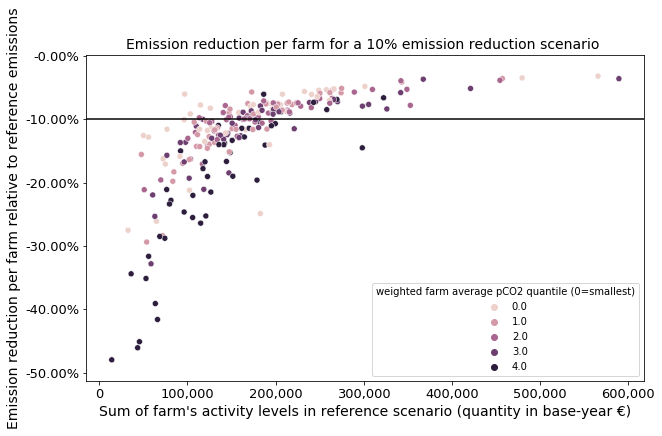

In [17]:
plt.figure(figsize=(10,6))
g=sns.scatterplot(x='farm_activity_level_ref', y='rel_farm_emissions', 
                  data=farm_emissions[farm_emissions['scen']=='scen4'], hue='weighted_mean_pCO2_quantile')

plt.xlabel("Sum of farm's activity levels in reference scenario (quantity in base-year €)", size=14)
plt.ylabel("Emission reduction per farm relative to reference emissions", size=14)
plt.title("Emission reduction per farm for a 10% emission reduction scenario ", size=14)
#g.set_yticklabels(g.get_yticks(), size = 14)
#g.set_xticklabels(g.get_xticks(), size = 13)
ylabels = ['{:,.2f}'.format(-(100-y*100))+'%' for y in g.get_yticks()]
g.set_yticklabels(ylabels, size = 13)
xlabels = ['{:,.0f}'.format(x*10000) for x in g.get_xticks()]
g.set_xticklabels(xlabels, size = 13)
g.axhline(0.9, color='black')
plt.legend (title = r"weighted farm average pCO2 quantile (0=smallest)")

Given that the data points are "crowded on the left side" it might be helpful to logarithmise the X-axis:

In [18]:
farm_emissions['log_farm_act_level_unsc']=farm_emissions['farm_activity_level_ref'].apply(lambda x: np.log10(x*10000))

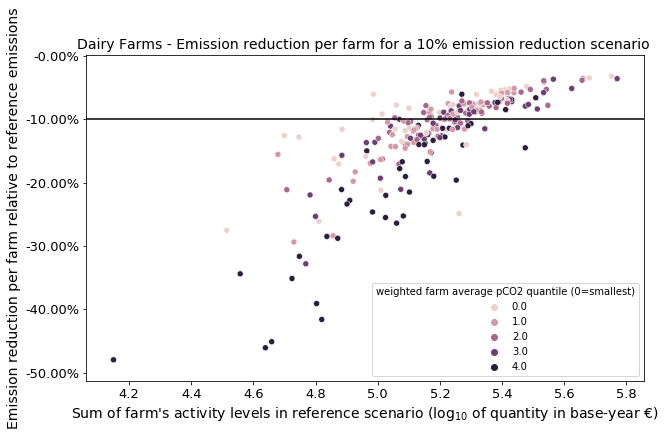

In [19]:
plt.figure(figsize=(10,6))
g=sns.scatterplot(x='log_farm_act_level_unsc', y='rel_farm_emissions', 
                  data=farm_emissions[farm_emissions['scen']=='scen4'], hue='weighted_mean_pCO2_quantile')

plt.xlabel(r"Sum of farm's activity levels in reference scenario ($\log_{10}$ of quantity in base-year €)", size=14)
plt.ylabel("Emission reduction per farm relative to reference emissions", size=14)
plt.title("Dairy Farms - Emission reduction per farm for a 10% emission reduction scenario ", size=14)
#g.set_yticklabels(g.get_yticks(), size = 14)
#g.set_xticklabels(g.get_xticks(), size = 13)
ylabels = ['{:,.2f}'.format(-(100-y*100))+'%' for y in g.get_yticks()]
g.set_yticklabels(ylabels, size = 13)
xlabels = ['{:,.1f}'.format(x) for x in g.get_xticks()]
g.set_xticklabels(xlabels, size = 13)
g.axhline(0.9, color='black')
plt.legend (title = r"weighted farm average pCO2 quantile (0=smallest)")
#plt.setp(g.get_legend().get_texts(), fontsize='13')
#plt.setp(g.get_legend().get_title(), fontsize='13') # for legend title


As hypothesized above, the emission reduction seems to depend also on the emission factor. A farm with a large weighted average pCO2 seems to have a higher emission reduction than a farm with a low average pCO2 - given that their reference activity level is the same. Again, farms above the black line are net buyers of emission certificates, because they reduce their emissions by less than what is required on average.

### 3. Classification

For the classification task, some further preparations are required or useful. <br>
First, let's create a dataframe that contains only the data for the 10% emission reduction scenario:

In [20]:
farm_emissions_10perc=farm_emissions[farm_emissions['scen']=='scen4']

Classification requires that the target variable (emission reduction) is categorical. Besides, we are interested in predicting if a farm is a net buyer or a net seller of emission rights. If its relative emission for the 10% reduction scenario is >0.9, then the farm reduces its emissions by less than 10%. That means that it contributes less than required to the emission reduction. It can only do this by buying emission certificates from farms that reduce their emissions by more than 10%. The categorical variable "net_emright_buyer" should be 1 if the farm is a net emission right buyer, and 0 otherwise:

In [21]:
def net_emright_buyer(relem):
    if relem > 0.9:
        return 1
    else: 
        return 0

In [22]:
farm_emissions_10perc['net_emright_buyer']=farm_emissions_10perc.apply(lambda x: net_emright_buyer(x.rel_farm_emissions), axis=1)
farm_emissions_10perc.dropna(inplace=True)

C:\Users\Josef\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Josef\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


We now create the features and the target variable. <br>
- Selected features are the __emission factor__ and the __reference activity level__. We will include both the continuous as well as the categorical emission factor so that we can later choose between either of them. <br>
- The target variable is __"net_emright_buyer"__. However, for plotting purposes it is convenient to also keep the continuous variable "rel_farm_emissions", even though it will __not__ serve as the target variable for classification. 


In [23]:
X=farm_emissions_10perc[['weighted_mean_pCO2_quantile','weighted_mean_pCO2','farm_activity_level_ref']]
y=farm_emissions_10perc[['net_emright_buyer','rel_farm_emissions']]

let's take a look at how many observations we got...

In [24]:
print(f'total observations: {len(X)}')

total observations: 234


especially for the KNN classification it is helpful to scale features, so that the absolute magnitute of a feature does not influence its impact. 

In [25]:
scaler = StandardScaler()
scaler.fit(X)
scaled_features = scaler.transform(X)

In [26]:
scaled_features=pd.DataFrame(scaled_features, columns=['weighted_mean_pCO2_quantile','weighted_mean_pCO2','farm_activity_level_ref'])

Finally, we will reserve some observations for a final classification, ensuring that none of the trained models has ever used them. This way we can treat them as "new" observations that can truly be predicted.  

In [27]:
#reserve 1/4 of all observations for final predictions with a selected model
X_prelim, X_final, y_prelim, y_final = train_test_split(scaled_features,y,test_size=0.25)

#### 3.1 K Nearest Neighbor Classification

In [28]:
#we will use the continuous feature "weighted_mean_pCO2"
selected_features=['weighted_mean_pCO2','farm_activity_level_ref']
#select net_emright_buyer as the target, which can be 0 or 1:
selected_target='net_emright_buyer'

An important determinant of the performance of KNN is the number of "nearest" neighbors. We will visualize below how this impacts prediction results. But let's explore the impact of K first by trying different values for K. <br>
The following loop incrementally raises K, predicts the y_test, and saves the error rate. For each K, we repeat this 100 times with different training and test samples to avoid that we draw conclusions from an "extreme" run. Finally, we plot the error rate on a graph.

In [29]:
error_rate_test = []
error_rate_training=[]
runs_per_size=100
for i in range(1,80,2):
    run_error_rate_test=[]
    run_error_rate_training=[]
    for run in range(runs_per_size):
        X_train, X_test, y_train, y_test = train_test_split(X_prelim,y_prelim,test_size=0.3)
        knn = KNeighborsClassifier(n_neighbors=i)
        knn.fit(X_train[selected_features],y_train[selected_target])
        pred_i_test = knn.predict(X_test[selected_features])
        pred_i_train = knn.predict(X_train[selected_features])
        run_error_rate_test.append(np.mean(pred_i_test != y_test[selected_target]))
        run_error_rate_training.append(np.mean(pred_i_train != y_train[selected_target]))
    error_rate_test.append(np.mean(run_error_rate_test))
    error_rate_training.append(np.mean(run_error_rate_training))
            

Text(0, 0.5, 'Error Rate')

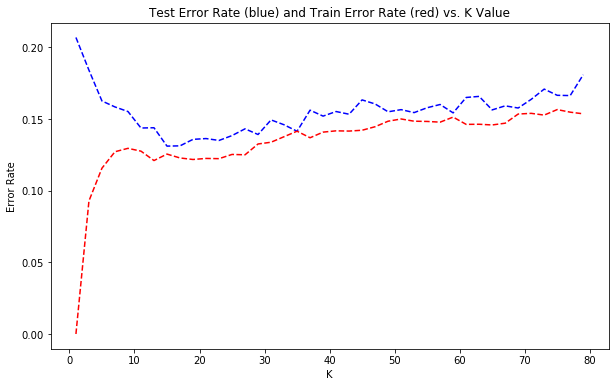

In [30]:
plt.figure(figsize=(10,6))
plt.plot(range(1,80,2),error_rate_test,color='blue', linestyle='dashed')
plt.plot(range(1,80,2),error_rate_training,color='red', linestyle='dashed')
        
plt.title('Test Error Rate (blue) and Train Error Rate (red) vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

The error rate of the _test_ drops with increasing K, around K=22 it reaches its lowest point (it might be different if you retry it), and then it increases again continuously. On the other hand, the error rate of the _training_ predictions is very low for low K, then increases sharply until it reaches roughly the level of the test predictions. So, what K is "best"? The error rate of the test data seems lowest around 22, so we will continue with it. We will see below why the error rate behaves like this.

In [31]:
# NOW WITH K=22
X_train, X_test, y_train, y_test = train_test_split(X_prelim,y_prelim,test_size=0.3,random_state=42)
knn = KNeighborsClassifier(n_neighbors=22)

knn.fit(X_train[selected_features],y_train[selected_target])
pred = knn.predict(X_test[selected_features])

print('WITH K=22')
print('\n')
print(confusion_matrix(y_test[selected_target],pred))
print('\n')
print(classification_report(y_test[selected_target],pred))

WITH K=22


[[25  3]
 [ 2 23]]


              precision    recall  f1-score   support

           0       0.93      0.89      0.91        28
           1       0.88      0.92      0.90        25

    accuracy                           0.91        53
   macro avg       0.91      0.91      0.91        53
weighted avg       0.91      0.91      0.91        53



In [32]:
print("Accuracy:",metrics.accuracy_score(y_test[selected_target],pred))

Accuracy: 0.9056603773584906


The prediction is quite good. In 88% of the cases it predicts net emission right buyers correctly, in 12% of the cases it erroneously predicts that they are net emission sellers. Let's visualize this:

In [33]:
X_test_df=pd.DataFrame(X_test)
y_test_df=pd.DataFrame(y_test)
y_pred_df=pd.DataFrame(pred, columns=['net_emright_buyer_pred'])
X_test_df.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)
KNN_result_df=pd.merge(X_test_df,y_test_df,left_index=True, right_index=True)
KNN_result_df=pd.merge(KNN_result_df,y_pred_df,left_index=True, right_index=True)

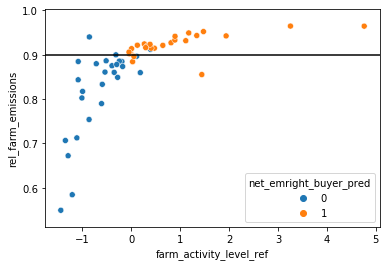

In [34]:
g=sns.scatterplot(x='farm_activity_level_ref', y='rel_farm_emissions', data=KNN_result_df, hue='net_emright_buyer_pred')
g.axhline(0.9, color='black')

Orange points above the black horizontal line were correctly predicted as net emission buyers, orange points below the black line are actually emission sellers but were predicted to be buyers. 

When plotting the relative farm emissions agains the weighted mean emission factor pCO2 we can see that there is a slight tendency for higher pCO2 to lead to stronger relative emission reductions. But this is not very clearly pronounced: 

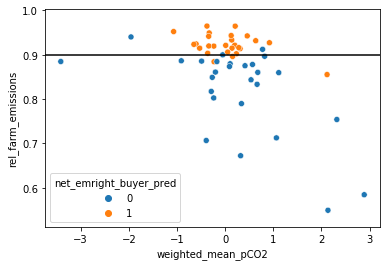

In [35]:
g=sns.scatterplot(x='weighted_mean_pCO2', y='rel_farm_emissions', data=KNN_result_df, hue='net_emright_buyer_pred')
g.axhline(0.9, color='black')

Let's visualize the classification surface, that is, the "neighborhood" that determines which class a test data point will be attributed to. Therefore, the following functions to create a meshgrid and to plot a contour are needed:

In [37]:
def create_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out


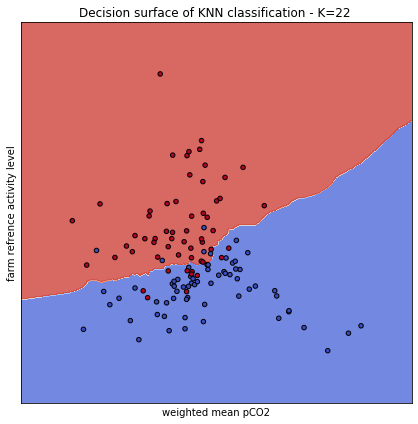

In [38]:
fig, ax = plt.subplots(figsize=(7,7))
# title for the plots
title = ('Decision surface of KNN classification - K=22 ')
# Set-up grid for plotting.
knn = KNeighborsClassifier(n_neighbors=22)
clf=knn.fit(X_train[selected_features],y_train[selected_target])
X0, X1 = X_train[selected_features].iloc[:, 0], X_train[selected_features].iloc[:, 1]
xx, yy = create_meshgrid(X0, X1)

plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=y_train[selected_target], cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_ylabel('farm refrence activity level')
ax.set_xlabel('weighted mean pCO2')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(title)
plt.show()

Some dots are misspecified, but the boundary is quite clear-cut. <br>
***
Why is the prediction so bad for K<10, for example, for K=2 (see above)? Because of overfitting! The training preditions are very good (see above), but the "neighborhoods" cannot be generalized for other data points that are not part of the training sample. 

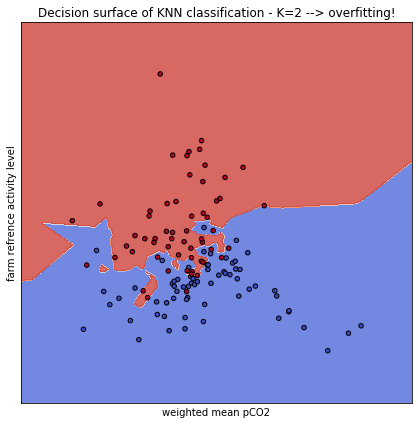

In [41]:
fig, ax = plt.subplots(figsize=(7,7))
# title for the plots
title = ('Decision surface of KNN classification - K=2 --> overfitting!')
# Set-up grid for plotting.
knn = KNeighborsClassifier(n_neighbors=2)
clf=knn.fit(X_train[selected_features],y_train[selected_target])
X0, X1 = X_train[selected_features].iloc[:, 0], X_train[selected_features].iloc[:, 1]
xx, yy = create_meshgrid(X0, X1)

plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=y_train[selected_target], cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_ylabel('farm refrence activity level')
ax.set_xlabel('weighted mean pCO2')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(title)
plt.show()

Finally, let's see why the error rate increases again if K becomes too large. Therefore, let's look at the size of the training data:

In [42]:
len(X_train)

122

When selecting a large K a significant share of the data points will always be neighbors! 

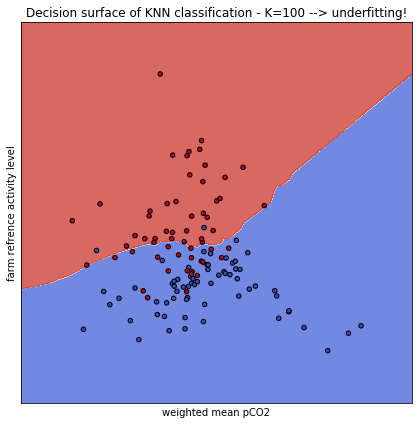

In [44]:
fig, ax = plt.subplots(figsize=(7,7))
# title for the plots
title = ('Decision surface of KNN classification - K=100 --> underfitting!')
# Set-up grid for plotting.
knn = KNeighborsClassifier(n_neighbors=100)
clf=knn.fit(X_train[selected_features],y_train[selected_target])
X0, X1 = X_train[selected_features].iloc[:, 0], X_train[selected_features].iloc[:, 1]
xx, yy = create_meshgrid(X0, X1)

plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=y_train[selected_target], cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_ylabel('farm refrence activity level')
ax.set_xlabel('weighted mean pCO2')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(title)
plt.show()

#### 3.2 Logistic Regression

In [45]:
#again, we will use the continuous feature "weighted_mean_pCO2"
selected_features=['weighted_mean_pCO2','farm_activity_level_ref']
#select net_emright_buyer as the target, which can be 0 or 1:
selected_target='net_emright_buyer'

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X_prelim, y_prelim, test_size=0.33, random_state=42)

For simplicity, we will not modify any parameters (such as penalty etc.):

In [47]:
logmodel = LogisticRegression()
logmodel.fit(X_train[selected_features],y_train[selected_target])

C:\Users\Josef\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [48]:
pred = logmodel.predict(X_test[selected_features])
print(classification_report(y_test[selected_target],pred))

              precision    recall  f1-score   support

           0       0.90      0.84      0.87        31
           1       0.83      0.89      0.86        27

    accuracy                           0.86        58
   macro avg       0.86      0.86      0.86        58
weighted avg       0.86      0.86      0.86        58



In [49]:
print("Accuracy:",metrics.accuracy_score(y_test[selected_target],pred))

Accuracy: 0.8620689655172413


the accuracy is a bit lower than using the KNN with K=22

We can retrieve the coefficients of the logistic classification. Their interpretation is different from the interpretation of linear regression parameters! The change of the target value probability (i.e., the probability that a farm is a net buyer of emissions) does __not__ decrease by 0.87 if pCO2 increases by 1! It only tells us that we are moving to the left by 0.87 on the X-axis. However, it alone does not tell us how this translates to the change on the y-Axis.

In [51]:
print(f'intercept:                            {float(logmodel.intercept_)}')
print(f'coefficient pCO2:            {logmodel.coef_[0][0]}')
print(f'coefficient reference activity level: {logmodel.coef_[0][1]}')

intercept:                            0.19110697890137182
coefficient pCO2:            -0.8660171594266434
coefficient reference activity level: 2.848463390263954


Again, let's plot the predictions:

In [52]:
X_test_df=pd.DataFrame(X_test)
y_test_df=pd.DataFrame(y_test)
y_pred_df=pd.DataFrame(pred, columns=['net_emright_buyer_pred'])
X_test_df.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)
LR_result_df=pd.merge(X_test_df,y_test_df,left_index=True, right_index=True)
LR_result_df=pd.merge(LR_result_df,y_pred_df,left_index=True, right_index=True)

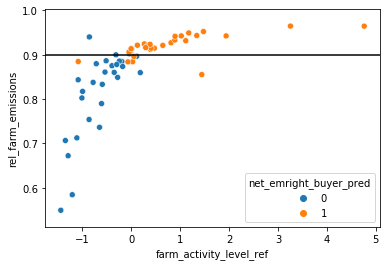

In [53]:
g=sns.scatterplot(x='farm_activity_level_ref', y='rel_farm_emissions', data=LR_result_df, hue='net_emright_buyer_pred')
g.axhline(0.9, color='black')

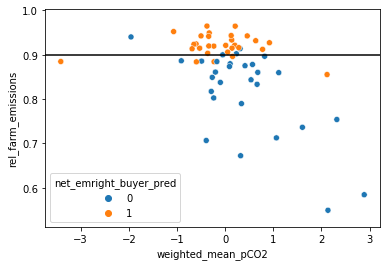

In [54]:
g=sns.scatterplot(x='weighted_mean_pCO2', y='rel_farm_emissions', data=LR_result_df, hue='net_emright_buyer_pred')
g.axhline(0.9, color='black')

We can plot the logistic regression. As we can only look at one feature at a time, let's keep the other feature constant at its mean:

In [87]:
mean_pCO2=X_test['weighted_mean_pCO2'].mean()
mean_actlev_ref=X_test['farm_activity_level_ref'].mean()

In [88]:
loss= expit(mean_pCO2* logmodel.coef_[0][0]+X_test['farm_activity_level_ref'] * logmodel.coef_[0][1]+ logmodel.intercept_).ravel()

Text(0.5, 0, 'reference farm activity level (scaled)')

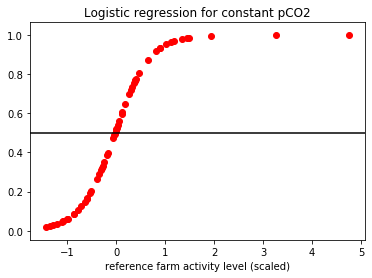

In [89]:
plt.scatter(X_test['farm_activity_level_ref'] , loss, color="red")
plt.axhline(0.5, color='black')
plt.title('Logistic regression for constant pCO2')
plt.xlabel('reference farm activity level (scaled)')

In [63]:
loss= expit(X_test['weighted_mean_pCO2']* logmodel.coef_[0][0]+mean_actlev_ref * logmodel.coef_[0][1]+ logmodel.intercept_).ravel()

Text(0.5, 0, 'weighted mean pCO2 (scaled)')

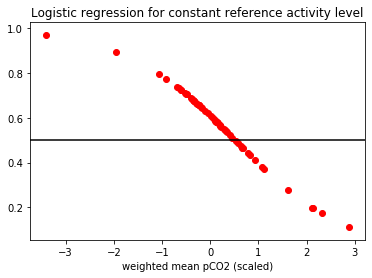

In [66]:
plt.scatter(X_test['weighted_mean_pCO2'] , loss, color="red")
plt.axhline(0.5, color='black')
plt.title('Logistic regression for constant reference activity level')
plt.xlabel('weighted mean pCO2 (scaled)')

Note that the probability of being a net emission buyer decreases with increasing pCO2

C:\Users\Josef\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


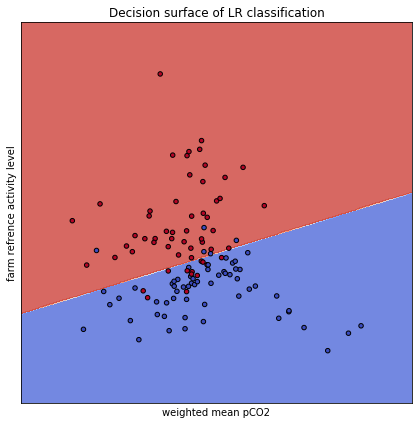

In [68]:
fig, ax = plt.subplots(figsize=(7,7))
# title for the plots
title = ('Decision surface of LR classification')
# Set-up grid for plotting.
clf=logmodel.fit(X_train[selected_features],y_train[selected_target])
X0, X1 = X_train[selected_features].iloc[:, 0], X_train[selected_features].iloc[:, 1]
xx, yy = create_meshgrid(X0, X1)

plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=y_train[selected_target], cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_ylabel('farm refrence activity level')
ax.set_xlabel('weighted mean pCO2')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(title)
plt.show()

#### 3.3 Support Vector Machine

In [69]:
selected_features=['weighted_mean_pCO2','farm_activity_level_ref']
#select net_emright_buyer as the target, which can be 0 or 1:
selected_target='net_emright_buyer'

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X_prelim, y_prelim, test_size=0.33, random_state=42)

In [71]:
svc_model = SVC(kernel='rbf')
svc_model.fit(X_train[selected_features],y_train[selected_target])

C:\Users\Josef\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [72]:
pred = svc_model.predict(X_test[selected_features])

In [73]:
print(confusion_matrix(y_test[selected_target],pred))

[[25  6]
 [ 3 24]]


In [74]:
print(classification_report(y_test[selected_target],pred))

              precision    recall  f1-score   support

           0       0.89      0.81      0.85        31
           1       0.80      0.89      0.84        27

    accuracy                           0.84        58
   macro avg       0.85      0.85      0.84        58
weighted avg       0.85      0.84      0.84        58



In [75]:
print("Accuracy:",metrics.accuracy_score(y_test[selected_target],pred))

Accuracy: 0.8448275862068966


let's see if we can improve the SVM using GridSearch Cross Validation to optimally tune the model parameters:

In [76]:
param_grid = [
    {'C':[0.5, 1, 10, 100],
    'gamma':['scale',1,0.1,0.01,0.001,0.0001],
    'kernel':['rbf']},    
]

optimal_params = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy',verbose=0)

optimal_params.fit(X_train[selected_features],y_train[selected_target])
print(optimal_params.best_params_)

{'C': 0.5, 'gamma': 'scale', 'kernel': 'rbf'}


C:\Users\Josef\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Let's use these optimal parameters in the new model:

In [77]:
svc_model = SVC(kernel='rbf', C=0.5, gamma='scale', random_state=42)
svc_model.fit(X_train[selected_features],y_train[selected_target])

SVC(C=0.5, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [78]:
pred = svc_model.predict(X_test[selected_features])

In [79]:
print(confusion_matrix(y_test[selected_target],pred))

[[26  5]
 [ 3 24]]


In [80]:
print("Accuracy:",metrics.accuracy_score(y_test[selected_target],pred))

Accuracy: 0.8620689655172413


The accuracy does indeed slightly improve. What does the decision surface look like?

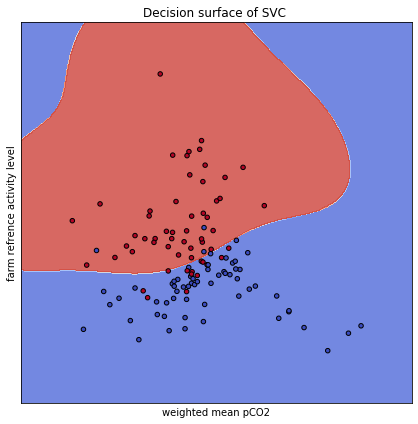

In [81]:
fig, ax = plt.subplots(figsize=(7,7))
# title for the plots
title = ('Decision surface of SVC ')
# Set-up grid for plotting.
clf=svc_model.fit(X_train[selected_features],y_train[selected_target])
X0, X1 = X_train[selected_features].iloc[:, 0], X_train[selected_features].iloc[:, 1]
xx, yy = create_meshgrid(X0, X1)

plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=y_train[selected_target], cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_ylabel('farm refrence activity level')
ax.set_xlabel('weighted mean pCO2')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(title)
plt.show()

### 4. Using one algorithm to predict "untouched" data

We will strictly base our decision which algorithm to pick on the accuracy - which is highest for KNN with K=22. There may be good reasons to use the Logistic Regression instead, if we believe that the "true" decision boundary is a straight line. But for the sake of this exercise, we will use KNN:

In [83]:
knn = KNeighborsClassifier(n_neighbors=22)
#fit it again with the training data to ensure we have the correct model for K=22:
knn.fit(X_train[selected_features],y_train[selected_target])

#now predict the "untouched" data:
pred = knn.predict(X_final[selected_features])

print('WITH K=22')
print('\n')
print(confusion_matrix(y_final[selected_target],pred))
print('\n')
print(classification_report(y_final[selected_target],pred))

WITH K=22


[[29  4]
 [ 4 22]]


              precision    recall  f1-score   support

           0       0.88      0.88      0.88        33
           1       0.85      0.85      0.85        26

    accuracy                           0.86        59
   macro avg       0.86      0.86      0.86        59
weighted avg       0.86      0.86      0.86        59



In [84]:
print("Accuracy:",metrics.accuracy_score(y_final[selected_target],pred))

Accuracy: 0.864406779661017


In [85]:
X_final_df=pd.DataFrame(X_final)
y_final_df=pd.DataFrame(y_final)
y_pred_df=pd.DataFrame(pred, columns=['net_emright_buyer_pred'])
X_final_df.reset_index(drop=True, inplace=True)
y_final_df.reset_index(drop=True, inplace=True)
SVM_result_df=pd.merge(X_final_df,y_final_df,left_index=True, right_index=True)
SVM_result_df=pd.merge(SVM_result_df,y_pred_df,left_index=True, right_index=True)

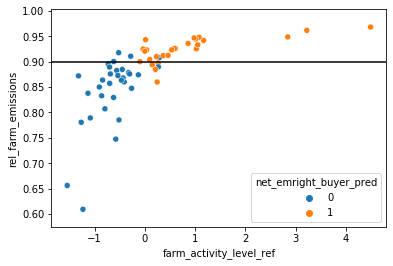

In [86]:
g=sns.scatterplot(x='farm_activity_level_ref', y='rel_farm_emissions', data=SVM_result_df, hue='net_emright_buyer_pred')
g.axhline(0.9, color='black')